# 自动微分
:label:`sec_autograd`

深度学习框架通过自动计算导数，即 *自动微分*（automatic differentiation）来加快求导。

* 实际中，根据设计好的模型，系统会构建一个 *计算图*（computational graph），来跟踪计算是哪些数据通过哪些操作组合起来产生输出。
* *自动微分* 使系统能够随后 *反向传播* 梯度。*反向传播*（backpropagate）意味着跟踪整个计算图，填充关于每个参数的偏导数。

## 一个简单的例子

假设我们想对函数 $y=2\mathbf{x}^{\top}\mathbf{x}$ 关于列向量 $\mathbf{x}$ 求导

首先，我们创建变量 `x` 并为其分配一个初始值。


In [3]:
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

在我们计算 $y$ 关于 $\mathbf{x}$ 的梯度之前，需要一个地方来存储梯度

我们不会在每次对一个参数求导时都分配新的内存。因为经常会成千上万次地更新相同的参数，每次都分配新的内存可能很快就会将内存耗尽。注意，一个标量函数关于向量 $\mathbf{x}$ 的梯度是向量，并且与 $\mathbf{x}$ 具有相同的形状。

**计算图的概念**

* 计算图是 PyTorch 用来跟踪张量操作的有向无环图(DAG)
* 当张量设置了 requires_grad=True 时，所有基于该张量的操作都会被记录在计算图中
* 这些记录用于后续的反向传播计算梯度

In [5]:
x.requires_grad_(True)  # 等价于x=torch.arange(4.0,requires_grad=True)
print(x)
print(x.grad)# 默认值是None

tensor([0., 1., 2., 3.], requires_grad=True)
None


(**现在计算$y$。**)


In [13]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

`x`是一个长度为4的向量，计算`x`和`x`的点积，得到了我们赋值给`y`的标量输出。
接下来，[**通过调用反向传播函数来自动计算`y`关于`x`每个分量的梯度**]，并打印这些梯度。


In [14]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

函数$y=2\mathbf{x}^{\top}\mathbf{x}$关于$\mathbf{x}$的梯度应为$4\mathbf{x}$。
让我们快速验证这个梯度是否计算正确。


In [24]:
x.grad == 4 * x
print(f"x: {x}")
print(f"x.grad: {x.grad}")

x: tensor([0., 1., 2., 3.], requires_grad=True)
x.grad: tensor([1., 1., 1., 1.])


[**现在计算`x`的另一个函数。**]

常数标量：如果标量是一个常数 $ c $，那么它的导数为： $$ \frac{d}{dx} c = 0 $$

变量标量：如果标量是自变量本身，例如 $ x $，那么它的导数为： $$ \frac{d}{dx} x = 1 $$

函数标量：如果标量是一个关于某个变量的函数 $ f(x) $，则其导数根据具体函数形式计算，例如：

对于 $ f(x) = x^2 $，导数为 $ f'(x) = 2x $
对于 $ f(x) = \sin(x) $，导数为 $ f'(x) = \cos(x) $


In [33]:
# 在默认情况下，PyTorch会累积梯度，我们需要清零 x 的梯度缓冲区，避免之前计算的梯度累积影响当前计算
x.grad.zero_()
print(f"x: {x}")
print(f"x.grad: {x.grad}")

# 计算 x 向量所有元素的和，得到标量 y
# y = x[0] + x[1] + x[2] + x[3]
y = x.sum()
print(f"y=x.sum(): {y}")

# 对标量 y 执行反向传播，计算 y 关于 x 的梯度
# 每个 x[i] 的偏导数都是 1
y.backward()
print(f"对标量 y 执行反向传播后，x的导数为： {x.grad}")

x: tensor([0., 1., 2., 3.], requires_grad=True)
x.grad: tensor([0., 0., 0., 0.])
y=x.sum(): 6.0
对标量 y 执行反向传播后，x的导数为： tensor([1., 1., 1., 1.])


## 非标量变量的反向传播

当 `y` 不是标量时，向量 `y` 关于向量 `x` 的导数的最自然解释是一个矩阵。
对于高阶和高维的 `y` 和 `x` ，求导的结果可以是一个高阶张量。

然而，虽然这些更奇特的对象确实出现在高级机器学习中（包括 [**深度学习中**] ），但当调用向量的反向计算时，我们通常会试图计算一批训练样本中每个组成部分的损失函数的导数。

**我们的目的不是计算微分矩阵，而是单独计算批量中每个样本的偏导数之和。**


In [45]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度。
# 本例只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()

# y = [x[0]*x[0], x[1]*x[1], x[2]*x[2], x[3]*x[3]]
y = x * x
print(f"y = x * x:\n {y}")

# z = x[0]*x[0] + x[1]*x[1] + x[2]*x[2] + x[3]*x[3] = 0 + 1 + 4 + 9 = 14
z = y.sum()
print(f"\nz = y.sum():\n {z}")

# 等价于y.backward(torch.ones(len(x)))
# 对标量 z 执行反向传播，计算 z 关于 x 的梯度，结果应为：[2x[0], 2x[1], 2x[2], 2x[3]] = [0, 2, 4, 6]
z.backward()
print(f"\n对向量 z 执行反向传播后，x 的导数为：\n{x.grad}")

y = x * x:
 tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)

z = y.sum():
 14.0

对向量 z 执行反向传播后，x 的导数为：
tensor([0., 2., 4., 6.])


## 分离计算

有时，我们希望 [**将某些计算移动到记录的计算图之外**]。

例如，假设 `y` 是作为 `x` 的函数计算的，而 `z` 则是作为 `y` 和 `x` 的函数计算的。
想象一下，我们想计算`z`关于`x`的梯度，但由于某种原因，希望将`y`视为一个常数，
并且只考虑到`x`在`y`被计算后发挥的作用。

这里可以分离`y`来返回一个新变量`u`，该变量与`y`具有相同的值，
但丢弃计算图中如何计算`y`的任何信息。
换句话说，梯度不会向后流经`u`到`x`。
因此，下面的反向传播函数计算`z=u*x`关于`x`的偏导数，同时将`u`作为常数处理，
而不是`z=x*x*x`关于`x`的偏导数。


In [53]:
x.grad.zero_()
print(f"x:\n{x}")

# y = [x[0]*x[0], x[1]*x[1], x[2]*x[2], x[3]*x[3]]
# 此操作会被记录在计算图中，因为 x 具有 requires_grad=True
y = x * x
print(f"\ny = x * x:\n{y}")

# u = [x[0]*x[0], x[1]*x[1], x[2]*x[2], x[3]*x[3]]
# 创建 y 的副本 u， u 与 y 数值相同，但脱离了计算图，不记录梯度信息
u = y.detach()
print(f"\nu = y.detach():\n{u}")

# z = [x[0]*x[0]*x[0], x[1]*x[1]*x[1], x[2]*x[2]*x[2], x[3]*x[3]*x[3]]
# 由于 u 脱离了计算图，此操作只记录 x 的贡献
z = u * x
print(f"\nz = u * x:\n{z}")

# w = [x[0]*x[0]*x[0] + x[1]*x[1]*x[1] + x[2]*x[2]*x[2] + x[3]*x[3]*x[3]]
# 对 z 求和得到标量 w = 36.0
w = z.sum()
print(f"\nw = z.sum():\n{w}")

# 计算 w 关于 x 的梯度：由于 w = u * x，且 u 被视为常数，所以 dw/dx = u，因此 x.grad 应该等于 u
w.backward()
print(f"\n对向量 w 执行反向传播后，x 的导数为：\n{x.grad}")
print(f"\n对向量 w 执行反向传播后，x 的导数是否与u相同：\n{x.grad == u}")

x:
tensor([0., 1., 2., 3.], requires_grad=True)

y = x * x:
tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)

u = y.detach():
tensor([0., 1., 4., 9.])

z = u * x:
tensor([ 0.,  1.,  8., 27.], grad_fn=<MulBackward0>)

w = z.sum():
36.0

对向量 w 执行反向传播后，x 的导数为：
tensor([0., 1., 4., 9.])

对向量 w 执行反向传播后，x 的导数是否与u相同：
tensor([True, True, True, True])


**detach()的作用机制**
* 数据共享：u = y.detach() 创建的新张量 u 与 y 共享相同的数据，数值完全相同
* 断开连接：u 不保留任何关于如何计算出 y 的信息，即断开了与 **计算图** 的连接，即，将 u 中的每个元素视为一个常数
* 梯度隔离：在后续计算中使用u时，梯度不会通过 u 反向传播到 y 的计算过程中

由于记录了`y`的计算结果，我们可以随后在`y`上调用反向传播，
得到`y=x*x`关于的`x`的导数，即`2*x`。


In [9]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## Python控制流的梯度计算

使用自动微分的一个好处是：

[**即使构建函数的计算图需要通过 Python 控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度**]。

在下面的代码中，`while`循环的迭代次数和`if`语句的结果都取决于输入`a`的值。


In [54]:
def f(a):
    b = a * 2
    while b.norm() < 1000: # b 不断乘以 2，直到其范数(default:L2)大于等于 1000 为止。
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

让我们计算梯度。


In [74]:
a = torch.randn(size=(), requires_grad=True)
print(a)
d = f(a)
d.backward()

tensor(1.3293, requires_grad=True)


`f` 函数在其输入 `a` 中是分段线性的。

对于任何 `a`，存在某个常量标量 `k`，使得 `f(a) = k * a` ，其中 `k` 的值取决于输入 `a` ，可以用 `f(a)/a` 验证梯度计算是否正确。

`f(a)/a` 代表了这个比例常数 k：
* 斜率: 在几何意义上，这表示函数图像的斜率
* 比例因子: 表示输出相对于输入的放大倍数
* 导数: 由于函数是分段线性的，`f(a)/a` 实际上就是该函数的导数（梯度）


In [78]:
print(f"a:\n{a}")
print(f"\nd:\n{d}")
print(f"\n对向量 d 执行反向传播后，x 的导数为：\n{a.grad}")
print(f"\n对向量 d 执行反向传播后，x 的导数是否与 f(a) / a 相同：\n{a.grad == f(a)  / a}")

a:
1.3292715549468994

d:
1361.174072265625

对向量 d 执行反向传播后，x 的导数为：
1024.0

对向量 d 执行反向传播后，x 的导数是否与 f(a) / a 相同：
True


## 小结

* 深度学习框架可以自动计算导数：我们首先将梯度附加到想要对其计算偏导数的变量上，然后记录目标值的计算，执行它的反向传播函数，并访问得到的梯度。

# 回忆数学概念
标准正态分布是一种重要的概率分布，其定义如下：
* 均值（期望）：μ = 0
* 标准差：σ = 1
* 方差：σ² = 1

数学表示：标准正态分布的概率密度函数为：

$$f(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$$

主要特征
* 对称性：关于y轴对称
* 峰值：在 x = 0 处达到最大值 $\frac{1}{\sqrt{2\pi}} \approx 0.3989$
* 拐点：在 x = ±1 处
* 尾部行为：随着|x|增大，函数值快速趋近于0

实际应用
* 在PyTorch中，torch.randn 函数就是用来生成服从标准正态分布的随机数，常用于：
* 神经网络权重的初始化
* 随机采样
* 生成噪声数据
* 蒙特卡洛模拟等场景

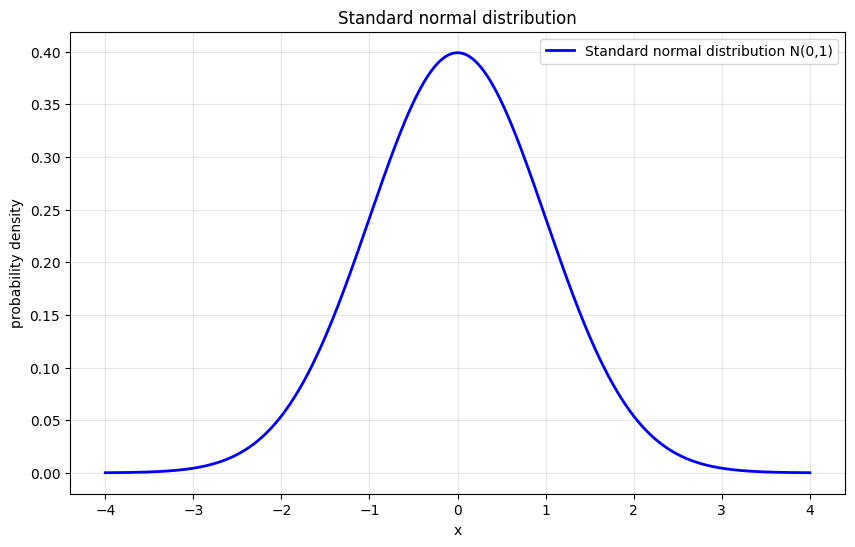

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 生成x轴数据
x = np.linspace(-4, 4, 1000)
# 计算标准正态分布的概率密度
y = norm.pdf(x, loc=0, scale=1)  # 均值=0, 标准差=1

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', linewidth=2, label='Standard normal distribution N(0,1)')
plt.xlabel('x')
plt.ylabel('probability density')
plt.title('Standard normal distribution')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


在标准正态分布中，拐点指的是概率密度函数曲线凹凸性发生变化的点。标准正态分布的拐点位于 $x = 1$ 和 $x = -1$ 处的数学解释：

对于标准正态分布的概率密度函数： $$f(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$$
拐点是函数二阶导数等于零的点，即 $f''(x) = 0$ 的解。

计算二阶导数：

$f'(x) = -x \cdot f(x)$

$f''(x) = (x^2 - 1) \cdot f(x)$

令 $f''(x) = 0$，得到： $(x^2 - 1) \cdot f(x) = 0$
由于 $f(x) > 0$ 恒成立，所以： $x^2 - 1 = 0$
解得：$x = 1$ 或 $x = -1$

几何意义
* 当 $|x| < 1$ 时，$f''(x) < 0$，曲线是凹的（向下弯曲）
* 当 $|x| > 1$ 时，$f''(x) > 0$，曲线是凸的（向上弯曲）
* 在 $x = ±1$ 处，曲线的凹凸性发生改变，因此这两个点是拐点
